# Preprocessing intracranial EEG using MNE-python

*NeuroHackademy 2022*  
Original author: [Liberty Hamilton, PhD](https://slhs.utexas.edu/research/hamilton-lab)  
Assistant Professor, Department of Speech, Language, and Hearing Sciences and  
Department of Neurology  
The University of Texas at Austin  

This notebook will show you how to preprocess intracranial EEG using MNE-python. This uses a freely available iEEG dataset on audiovisual movie watching from [Julia Berezutskaya, available on OpenNeuro.org](https://openneuro.org/datasets/ds003688/versions/1.0.7/metadata). This notebook mostly covers the basics of how to look at iEEG data, and my tutorial will discuss how to find and identify artifacts. The method of high gamma extraction is identical to that used in [Hamilton et al. 2018](https://doi.org/10.1016/j.cub.2018.04.033) and [Hamilton et al. 2021](https://doi.org/10.1016/j.cell.2021.07.019).

## Python libraries used in this tutorial

* MNE-python
* numpy
* pandas
* matplotlib

## What you will do in this tutorial

* Load an iEEG dataset in MNE-python
* Compare iEEG dataset with BIDs metadata vs. without so you know what to do if you encounter data without this info
* Plot the power spectrum of the data to check for bad channels and compare channel types
* Re-reference the data according to different reference schemes
* Compute the high gamma analytic amplitude of the signal
* Plot evoked data

In [2]:
import mne
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report
from mne_bids.path import get_bids_path_from_fname
from ecog_preproc_utils import transformData
#import datalad.api as dl
#%matplotlib notebook
#!pip install ipympl
#!pip install mne_bids
#%matplotlib qt
#%matplotlib tk

## Download BIDS iEEG dataset

Here we will download an example iEEG dataset from [Berezutskaya et al.  Open multimodal iEEG-fMRI dataset from naturalistic stimulation with a short audiovisual film.](https://openneuro.org/datasets/ds003688/versions/1.0.7/metadata). 

In [3]:
# Change these variables to work for your block
subj = '07'
sess = 'iemu'
task = 'rest'
acq = 'clinical'
run = '1'

data_home_dir = "/home/jovyan/aws_ds003688"
data_dir = f"{data_home_dir}/sub-{subj}/ses-{sess}/ieeg"
output_dir =  f'{data_home_dir}/derivatives/'

In [ ]:
# ds = dl.Dataset(data_home_dir)
# ds.get(data_dir)

In [4]:
bids_path = BIDSPath (subject=subj, session = sess, task = task, \
                 acquisition = acq, run = run, root = data_home_dir, datatype ='ieeg')
bids_path

BIDSPath(
root: /home/jovyan/aws_ds003688
datatype: ieeg
basename: sub-07_ses-iemu_task-rest_acq-clinical_run-1)

In [ ]:
# #Change the data directory below to where your data are located. 
# data_home_dir = "/home/jovyan/ds003688"
# #data_dir = data_home_dir/f"sub-{subj}"/f"ses-{sess}"/f"ieeg"
# data_dir = f'{data_home_dir}/sub-{subj}/ses-{sess}/ieeg'
# channel_path = f'{data_dir}sub-{subj}_ses-{sess}_task-{task}_acq-{acq}_run-{run}_channels.tsv'
# raw_path = f'{data_dir}/sub-{subj}_ses-{sess}_task-{task}_acq-{acq}_run-{run}_ieeg.vhdr'

# bids_path = get_bids_path_from_fname(raw_path)
# base_name = os.path.basename(raw_path).split('.')[0]

# print(base_name)
# #print(bids_path)

In [5]:
# Read data and extract parameters from BIDS files
raw = read_raw_bids(bids_path, verbose=True)

Extracting parameters from /home/jovyan/aws_ds003688/sub-07/ses-iemu/ieeg/sub-07_ses-iemu_task-rest_acq-clinical_run-1_ieeg.vhdr...
Setting channel info structure...
Reading events from /home/jovyan/aws_ds003688/sub-07/ses-iemu/ieeg/sub-07_ses-iemu_task-rest_run-1_events.tsv.
Reading channel info from /home/jovyan/aws_ds003688/sub-07/ses-iemu/ieeg/sub-07_ses-iemu_task-rest_acq-clinical_run-1_channels.tsv.
Reading electrode coords from /home/jovyan/aws_ds003688/sub-07/ses-iemu/ieeg/sub-07_ses-iemu_acq-clinical_electrodes.tsv.


/tmp/ipykernel_117/531307012.py:2: RuntimeWarning: The unit for channel(s) MKR+ has changed from V to NA.
  raw = read_raw_bids(bids_path, verbose=True)
/tmp/ipykernel_117/531307012.py:2: RuntimeWarning: participants.tsv file not found for /home/jovyan/aws_ds003688/sub-07/ses-iemu/ieeg/sub-07_ses-iemu_task-rest_acq-clinical_run-1_ieeg.vhdr
  raw = read_raw_bids(bids_path, verbose=True)


In [ ]:
# Read the data assuming we didn't have the BIDS structure in place
#raw_nobids = mne.io.read_raw_brainvision(raw_path, preload=True)

In [ ]:
# data = raw_nobids.get_data()
# data.shape

In [6]:
raw.load_data()
raw.info

Reading 0 ... 100291  =      0.000 ...   195.881 secs...


<Info | 10 non-empty values
 bads: 1 items (C16)
 ch_names: FB1, FB2, FB3, FB4, FB5, FB6, FB7, FB8, IHv1, IHv2, IHv3, IHv4, ...
 chs: 56 ECoG, 1 ECG, 1 EOG, 3 EMG, 1 Stimulus
 custom_ref_applied: False
 dig: 56 items (56 EEG)
 highpass: 0.0 Hz
 line_freq: 50.0
 lowpass: 256.0 Hz
 meas_date: 1900-01-01 00:00:00 UTC
 nchan: 62
 projs: []
 sfreq: 512.0 Hz
>

In [32]:
raw.set_meas_date(None)

<RawBrainVision | sub-07_ses-iemu_task-rest_acq-clinical_run-1_ieeg.eeg, 55 x 100292 (195.9 s), ~42.2 MB, data loaded>

In [33]:
# drset_meas_datechannels
raw.drop_channels(raw.info['bads'])
# select only ecog channels
raw.pick_types(ecog=True)

<RawBrainVision | sub-07_ses-iemu_task-rest_acq-clinical_run-1_ieeg.eeg, 55 x 100292 (195.9 s), ~42.2 MB, data loaded>

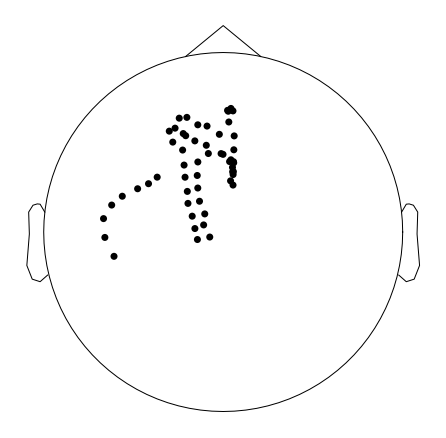

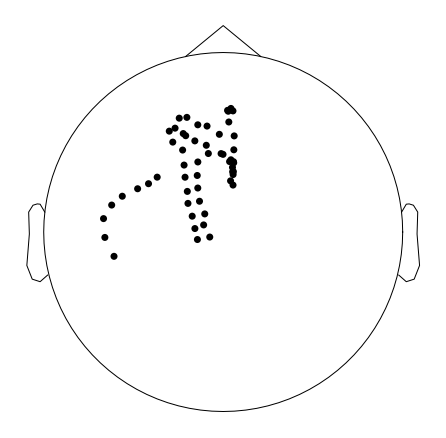

In [8]:
raw.plot_sensors()

## Plot the power spectrum

Now we will plot the power spectrum of the signal to give us an idea of the signals we're getting. Bad channels (or channels that are not EEG/ECoG) will often have a very different power spectrum than the good channels. These will show up as highly outside the range of the other channels (either flat, or much higher/lower power).

Effective window size : 4.000 (s)


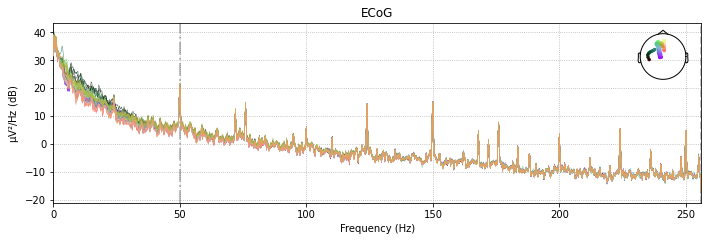

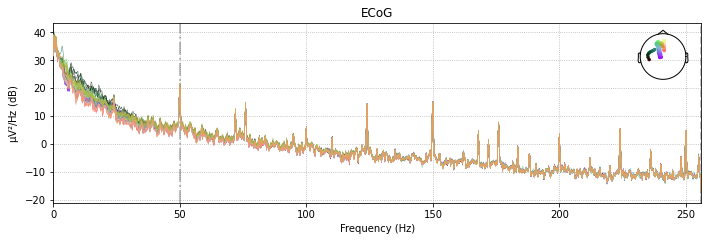

In [9]:
raw.plot_psd()

In [ ]:
# Plot the data, reject bad segments. Look for times where there
# are spike wave discharges (epileptiform artifacts) or large
# movement artifacts. Be selective, look out for blocks with a 
# ton of seizure activity
#raw_nobids.plot(scalings='auto', color=dict(eeg='b', ecog='b'), n_channels=64, block=True)

## Referencing

Referencing or re-referencing your data should be done with some knowledge of your recording setup and what you wish to measure. You can read more about referencing [here (for EEG)](https://pressrelease.brainproducts.com/referencing/#:~:text=The%20reference%20influences%20the%20amplitude,affected%20by%20similar%20electrical%20activity.). Typically, experimenters will choose one of the following references:

1. Based on a single electrode in white matter (or relatively "quiet" electrode far away from your signals of interest. 
2. Based on the average of all electrodes or a block of electrodes (CAR or Common Average Reference). Note that the CAR is *not* a good idea if all of your electrodes are within a single functional area, as you will likely subtract out more signal than noise. 
3. Bipolar referencing, in which pairs of adjacent electrodes are subtracted to calculate more local signals. This is a bit more complicated but allows you to work with data in a single region without the drawbacks of the CAR.

ECoG channel type selected for re-referencing
Applying average reference.
Applying a custom ('ECoG',) reference.
Opening raw-browser...


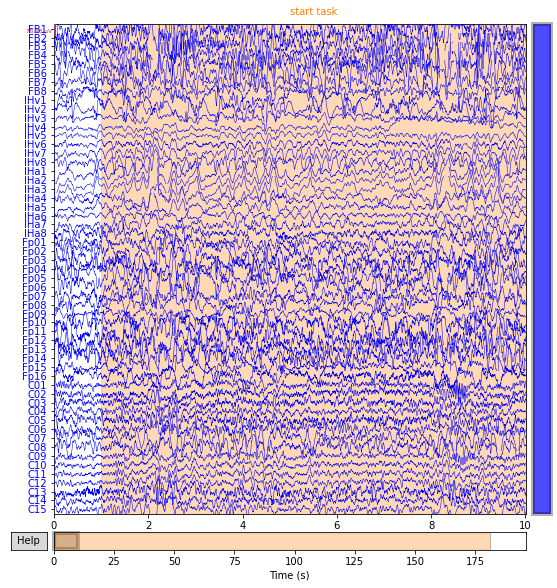

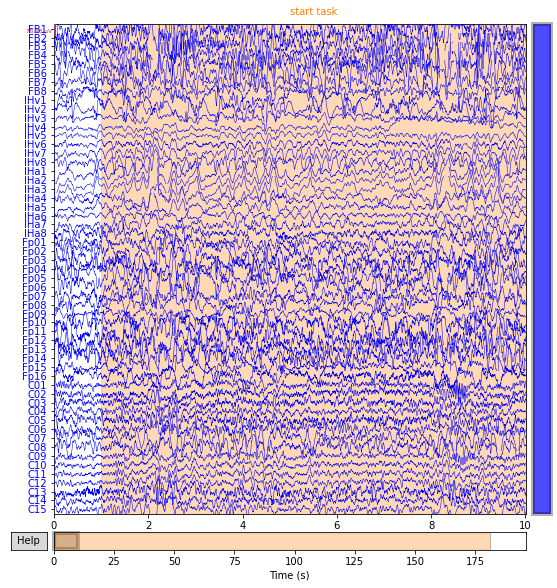

In [34]:
# Example of common average reference
raw_ref_car = raw.copy()
raw_ref_car.set_eeg_reference(ref_channels = 'average')
raw_ref_car.plot(scalings='auto', color=dict(eeg='b', ecog='b'), n_channels=64, block=True)

Effective window size : 4.000 (s)


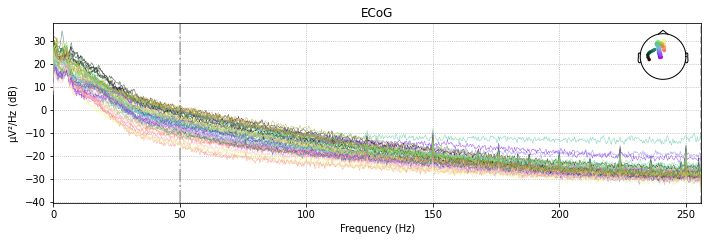

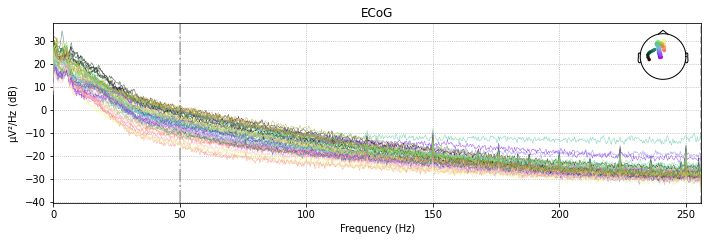

In [35]:
raw_ref_car.plot_psd()

### Saving the CAR data

In [37]:
#try:
deriv_dir = f'{data_home_dir}/derivatives/CAR'
print(deriv_dir)
fname = os.path.join(deriv_dir, f'{bids_path.basename}_CAR_raw.fif')
raw_ref_car.save(fname, overwrite=True)
#except:
 #   print("Can't save raw. Do you need to set overwrite=True?")

Overwriting existing file.
Writing /home/jovyan/aws_ds003688/derivatives/CAR/sub-07_ses-iemu_task-rest_acq-clinical_run-1_CAR_raw.fif
Closing /home/jovyan/aws_ds003688/derivatives/CAR/sub-07_ses-iemu_task-rest_acq-clinical_run-1_CAR_raw.fif
[done]


## Bipolar reference

Bipolar referencing is a bit trickier and is not fully implemented here. You need to use knowledge of the physical locations of the electrodes to properly create the bipolar montage. For example, in the image below, we would need to use the knowledge of how the electrodes are placed in order to create the appropriate pairs for the anode and cathode.

![sub-06 electrode locations](sub-06_ses-iemu_acq-render_photo_ecog_left.jpeg)

In [ ]:
# Example of bipolar reference
#raw_ref_bip = mne.set_bipolar_reference(raw, anode=['P01', 'P02'], cathode=['P02','P03'])
#raw_ref_bip.plot(scalings='auto', color=dict(eeg='b', ecog='b'), n_channels=64, block=True)

# Calculate the high gamma transform of your data

Now we will take the raw, preprocessed data, and convert to high gamma analytic amplitude for further analysis. The high gamma analytic amplitude is used in many papers as a proxy for multi-unit firing (see [Ray and Maunsell, PLoS Biology 2011](https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.1000610)).

This particular version of the high gamma transform uses the same procedure as used in [Hamilton et al. 2018](cell.com/current-biology/pdf/S0960-9822(18)30461-5.pdf) and [Hamilton et al. 2021](https://www.cell.com/cell/pdf/S0092-8674(21)00878-3.pdf). The basic idea is to take 8 bands within the 70-150 Hz range, calculate the Hilbert transform, then take the analytic amplitude of that signal and average across the 8 bands. This form of averaging results in higher SNR than one band between 70-150 Hz. 

Doing CAR on
average
ECoG channel type selected for re-referencing
Applying average reference.
Applying a custom ('ECoG',) reference.
Opening raw-browser...


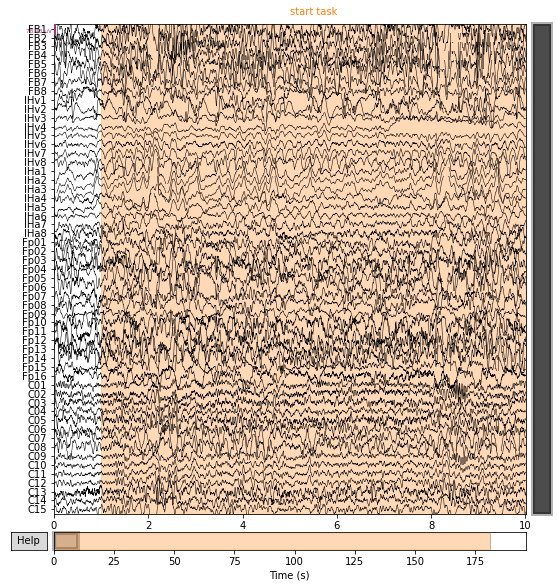

Getting frequency bands for Hilbert transform
Getting high_gamma band data
Creating directory /home/jovyan/aws_ds003688/sub-07/ses-iemu/ieeg/HilbAA_70to150_8band
Getting the raw data array


applying Hilbert transform...:   0%|          | 0/8 [00:00<?, ?it/s]/home/jovyan/ieeg preprocessing/ecog_preproc_utils.py:155: ComplexWarning: Casting complex values to real discards the imaginary part
  hilbdat[ch,:] = applyHilbertTransform(raw_data[ch,:], raw.info['sfreq'], ct, sd)
applying Hilbert transform...:  12%|█▎        | 1/8 [00:08<01:00,  8.60s/it]

Taking log transform of high gamma


applying Hilbert transform...:  25%|██▌       | 2/8 [00:11<00:32,  5.36s/it]

Taking log transform of high gamma


applying Hilbert transform...:  38%|███▊      | 3/8 [00:14<00:21,  4.28s/it]

Taking log transform of high gamma


applying Hilbert transform...:  50%|█████     | 4/8 [00:17<00:15,  3.79s/it]

Taking log transform of high gamma


applying Hilbert transform...:  62%|██████▎   | 5/8 [00:20<00:10,  3.57s/it]

Taking log transform of high gamma


applying Hilbert transform...:  75%|███████▌  | 6/8 [00:23<00:06,  3.37s/it]

Taking log transform of high gamma


applying Hilbert transform...:  88%|████████▊ | 7/8 [00:26<00:03,  3.25s/it]

Taking log transform of high gamma


applying Hilbert transform...: 100%|██████████| 8/8 [00:29<00:00,  3.73s/it]

Taking log transform of high gamma


Taking the mean across 8 bands
Z-scoring signal
Creating RawArray with float64 data, n_channels=55, n_times=100292
    Range : 0 ... 100291 =      0.000 ...   195.881 secs
Ready.
Opening raw-browser...


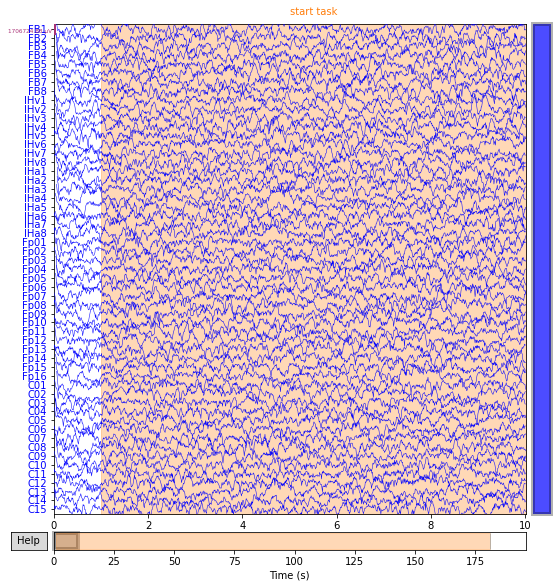

In [38]:
# Get the high gamma data (the entire signal)
# Generally, do a CAR if you have widespread coverage over multiple
# areas (not just one sensory area)
# If you have limited coverage, you may choose to do no CAR or choose
# to reference to one specific channel.
hgdat = transformData(raw, data_dir, band='high_gamma', notch=False, CAR=True,
                      car_chans='average', log_transform=True, do_zscore=True,
                      hg_fs=100, notch_freqs=[150, 250], overwrite=False,
                      ch_types='eeg', save=False)


In [44]:
deriv_dir = f'{data_home_dir}/derivatives/HighGamma'
print(deriv_dir)
fname = os.path.join(deriv_dir, f'{bids_path.basename}_CAR_raw.fif')
hgdat.save(fname, overwrite=True)


/home/jovyan/aws_ds003688/derivatives/HighGamma
Writing /home/jovyan/aws_ds003688/derivatives/HighGamma/sub-07_ses-iemu_task-rest_acq-clinical_run-1_CAR_raw.fif
Closing /home/jovyan/aws_ds003688/derivatives/HighGamma/sub-07_ses-iemu_task-rest_acq-clinical_run-1_CAR_raw.fif
[done]


In [45]:
hg = hgdat.get_data()

In [46]:
coor_map = np.corrcoef(hg)

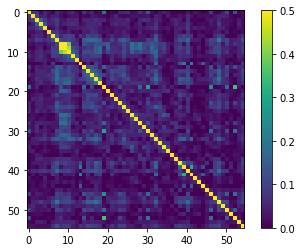

In [47]:
plt.imshow(coor_map)
plt.clim(0, 0.5)
plt.colorbar()

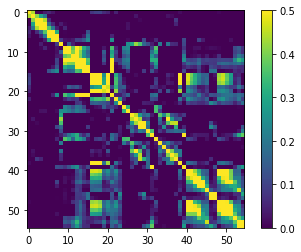

In [50]:
car_dat = raw_ref_car.get_data()
coor_map_car = np.corrcoef(car_dat)
plt.imshow(coor_map_car)
plt.clim(0, 0.5)
plt.colorbar()

In [40]:
data = raw.get_data()

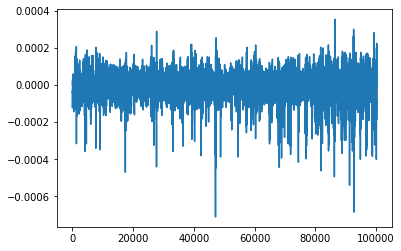

In [43]:
plt.plot(data[1,:])